In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve
import scipy.io as sio
import warnings
import seaborn as sns
import audio2numpy as a2n

warnings.filterwarnings('ignore')

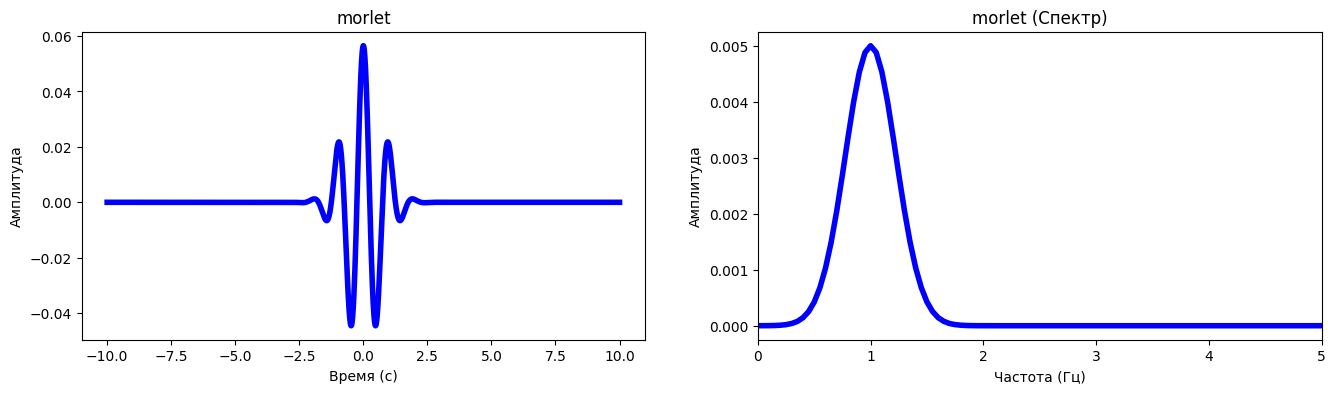

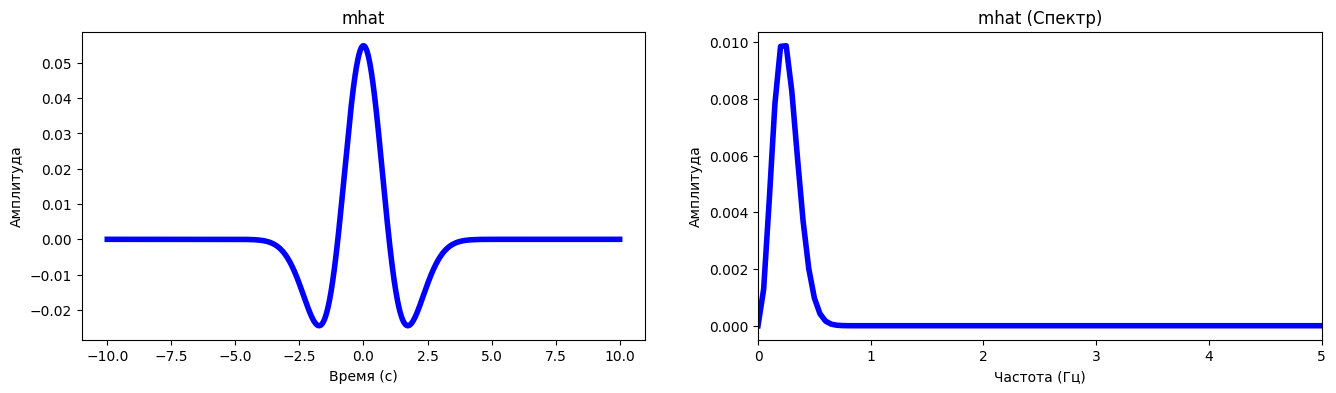

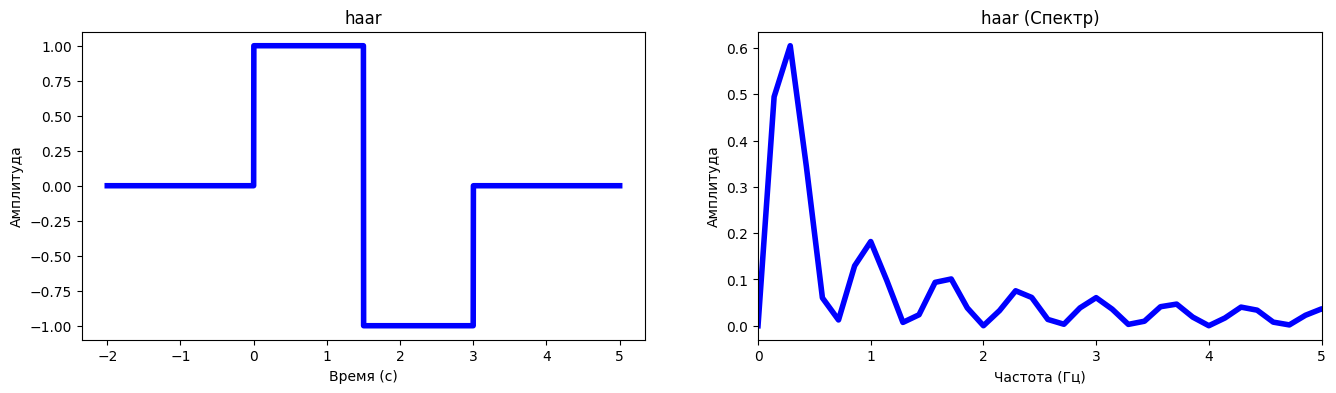

In [15]:
def wavelet_morlet(t, peak_freq=1.0, alpha=1.0):
    psi = np.exp(-t**2 / alpha**2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_mhat(t, peak_freq=0.0):
    psi = (1 - t**2) * np.exp(-t**2 / 2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_haar(t, peak_freq=1.0, T=1, shift=0):
    t_scaled = t * peak_freq
    return np.array([1 if (t_scaled >= shift) and (t_scaled < T/2 + shift) else -1 if (t_scaled >= T/2 + shift) and (t_scaled < T + shift)
                     else 0 for t_scaled in np.nditer(t_scaled)])

wavelets = {
    "morlet": {
        "func": wavelet_morlet,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'morlet',
        "params": {"alpha": 1.0, "peak_freq": 1.0},
        "line_style": (5, (10, 3)),
        "line_width": 4,
        "color": "blue"
    },
    "mhat": {
        "func": wavelet_mhat,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'mhat',
        "params": {},
        "line_style": (0, (1, 1)),
        "line_width": 4,
        "color": "blue"
    },
    "haar": {
        "func": wavelet_haar,
        "num": 5000,
        "t": np.linspace(-2, 5, 5000),
        "name": 'haar',
        "params": {"T": 3, "shift": 0},
        "line_style": "--",
        "line_width": 2,
        "color": "blue"
    },
}

for wavelet in wavelets.values():
    y = wavelet["func"](wavelet["t"], **wavelet["params"])
    freq = np.fft.rfftfreq(len(wavelet["t"]), d=(wavelet["t"][1]-wavelet["t"][0]))
    yff = np.fft.rfft(y)
    wavelet["y"] = y
    wavelet["freq"] = freq
    wavelet["yff"] = yff
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    axs[0].plot(wavelet["t"], y, linewidth=4, color=wavelet["color"])
    axs[0].set_title(wavelet["name"])
    axs[0].set_xlabel('Время (с)')
    axs[0].set_ylabel('Амплитуда')
    axs[1].plot(freq, np.abs(yff) / wavelet["num"] * 2, linewidth=4, color=wavelet["color"])
    axs[1].set_xlim(0, 5)
    axs[1].set_title(wavelet["name"] + " (Спектр)")
    axs[1].set_xlabel('Частота (Гц)')
    axs[1].set_ylabel('Амплитуда')
    plt.show()

In [16]:
def add_noise(signal, noise_level=1):
    return signal + np.random.normal(0, 0, signal.shape)

def cos_signal(t, f, A=1):
    y = 0
    for i in f:
        w = 2 * np.pi * i
        y += A * np.cos(w * t)
    return y

num = 5000  # количество отсчетов
# f = [2, 5, 15, 50]
f = [2]
# создание сигнала
t = np.linspace(0, 3, num)
y = cos_signal(t, f)
np.random.seed(40)
y_noised = add_noise(y, 3)

# fft
freq = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
# yff_signal = np.fft.rfft(y_noised)
yff_signal = np.fft.rfft(y)

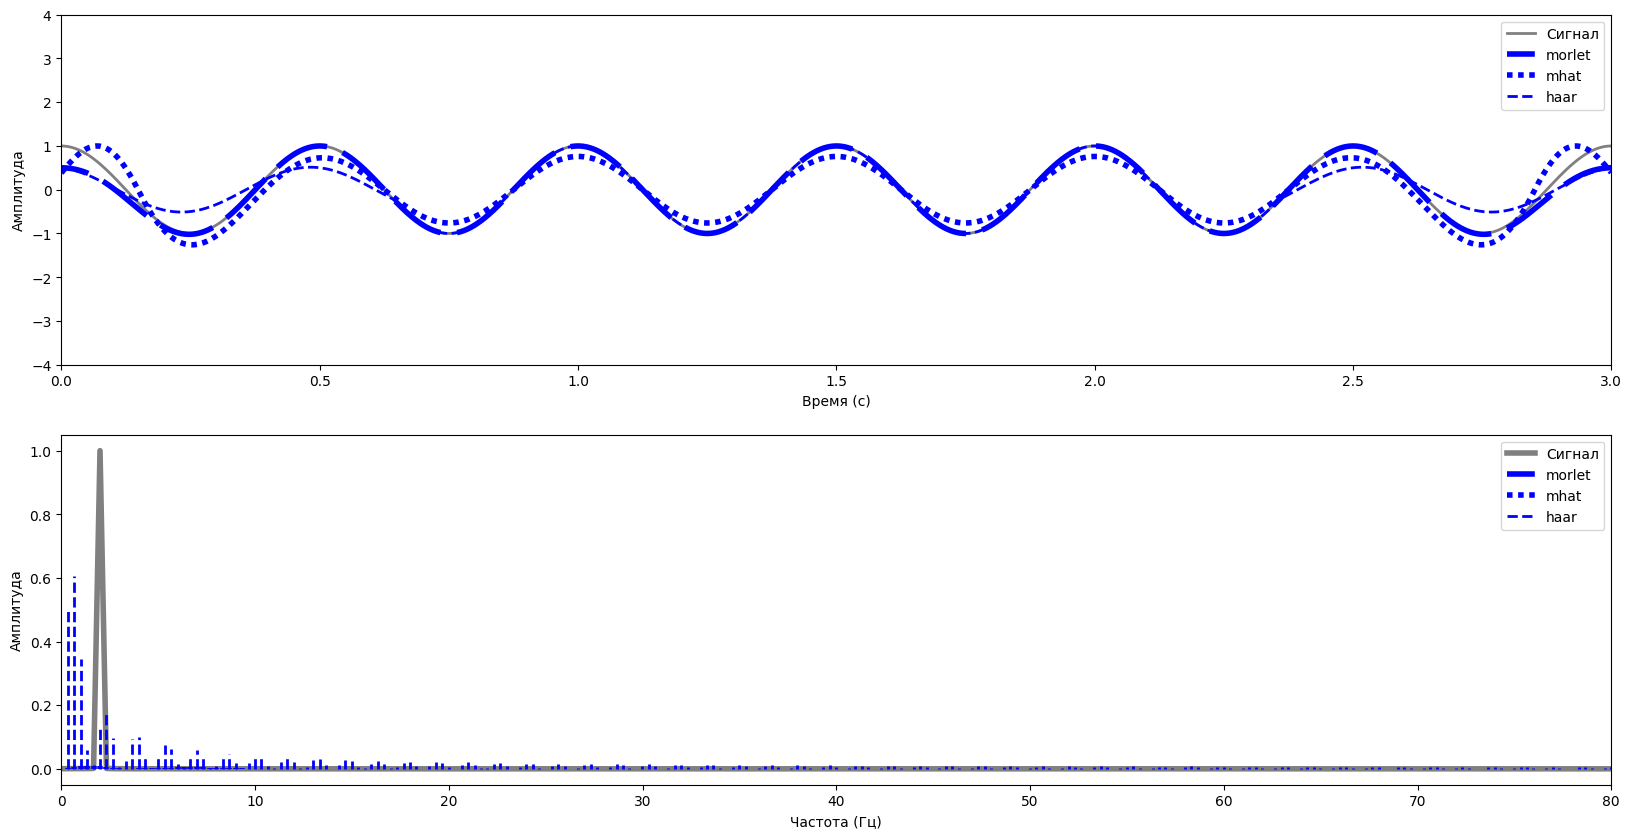

In [17]:
# wavelets apply
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, y_noised, linewidth=2, label='Сигнал', color="grey")
axs[0].set_xlabel('Время (с)')
axs[0].set_ylabel('Амплитуда')
axs[0].set_ylim(-4, 4)
axs[0].set_xlim(0, 3)
axs[1].plot(freq, np.abs(yff_signal) / num * 2, linewidth=4, label='Сигнал', color="grey")
axs[1].set_xlabel('Частота (Гц)')
axs[1].set_ylabel('Амплитуда')
axs[1].set_xlim(0, 80)

for i, wavelet in enumerate(wavelets.values()):
    filtered = (convolve(y_noised, np.abs(wavelet["y"]), mode="same"))
    yff_morlet = np.fft.rfft(filtered)
    # plots
    k_scale = np.max(y_noised)
    axs[0].plot(t, filtered / np.max(filtered), label=wavelet['name'], color=wavelet["color"], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])
    axs[1].vlines(freq, 0, np.abs(wavelet['yff']) / wavelet['num'] * 2, color=wavelet['color'], label=wavelet['name'], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])

axs[0].legend()
axs[1].legend()
plt.show()

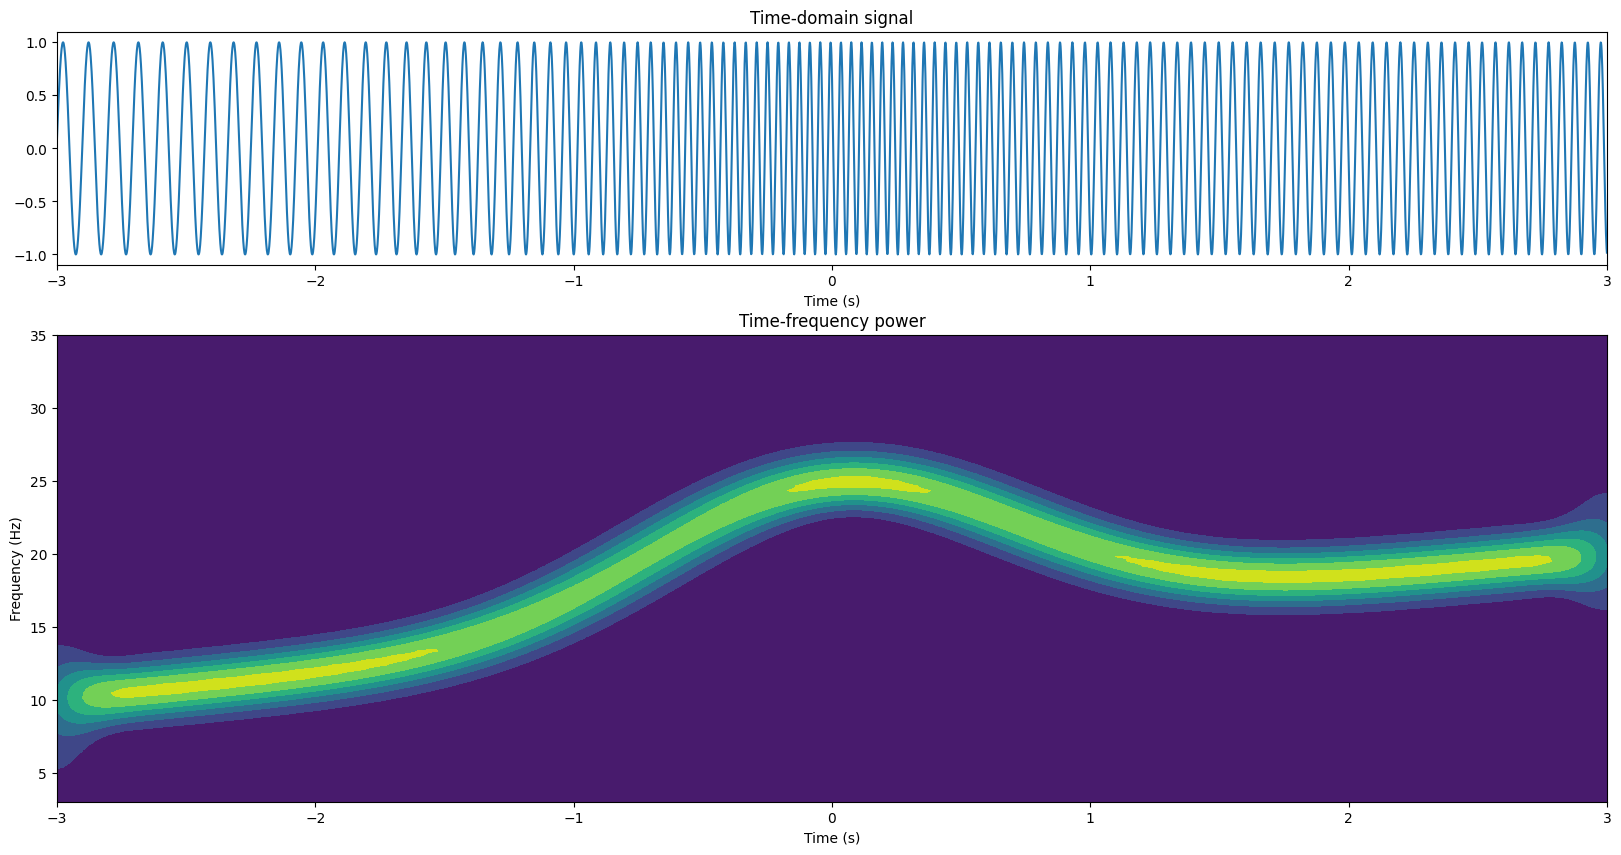

In [18]:
t = np.linspace(-3, 3, 5000)

# Смещение частот
freq_move = 10
# Сигнал обратной экспоненты, дополненный на отрицательную часть
freqmod = np.exp(-t**2) * 10 + freq_move
# Добавим линейный рост частот
freqmod += np.linspace(0, 10, len(t))

signal = np.sin(12 * np.pi * np.cumsum(freqmod) / len(t))

def make_spectrogram(wavelet_function, t, signal, freqs, shift=1.0, **args):
    # Пустой список для хранения вейвлетов
    wavelets = []
    # Цикл по всем частотам
    for freq in freqs:
        wavelet = wavelet_function(t, freq, **args)
        # Центрирование вейвлета
        wavelet = np.roll(wavelet, int(-len(wavelet) / shift))
        wavelets.append(wavelet)
    # Преобразование списка в массив NumPy
    wavelets = np.array(wavelets)

    # Пустой список для хранения результатов свертки
    tf = []
    # Цикл по всем вейвлетам
    for wavelet in wavelets:
        # Свертка вейвлета и сигнала
        tf.append(np.abs(convolve(signal, wavelet, 'same')))
    # Преобразование списка в массив NumPy
    tf = np.array(tf)

    return tf


# Перебираемые частоты вейвлетов
freqs = np.linspace(3, 35, 100)
tf = make_spectrogram(wavelet_morlet, t, signal, freqs, alpha=0.17)

fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 2]})

axs[0].plot(t, signal)
axs[0].set_xlim(-3, 3)
axs[0].set_title("Time-domain signal")
axs[0].set_xlabel('Time (s)')

axs[1].contourf(t, freqs, tf)
axs[1].set_title("Time-frequency power")
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')
plt.show()

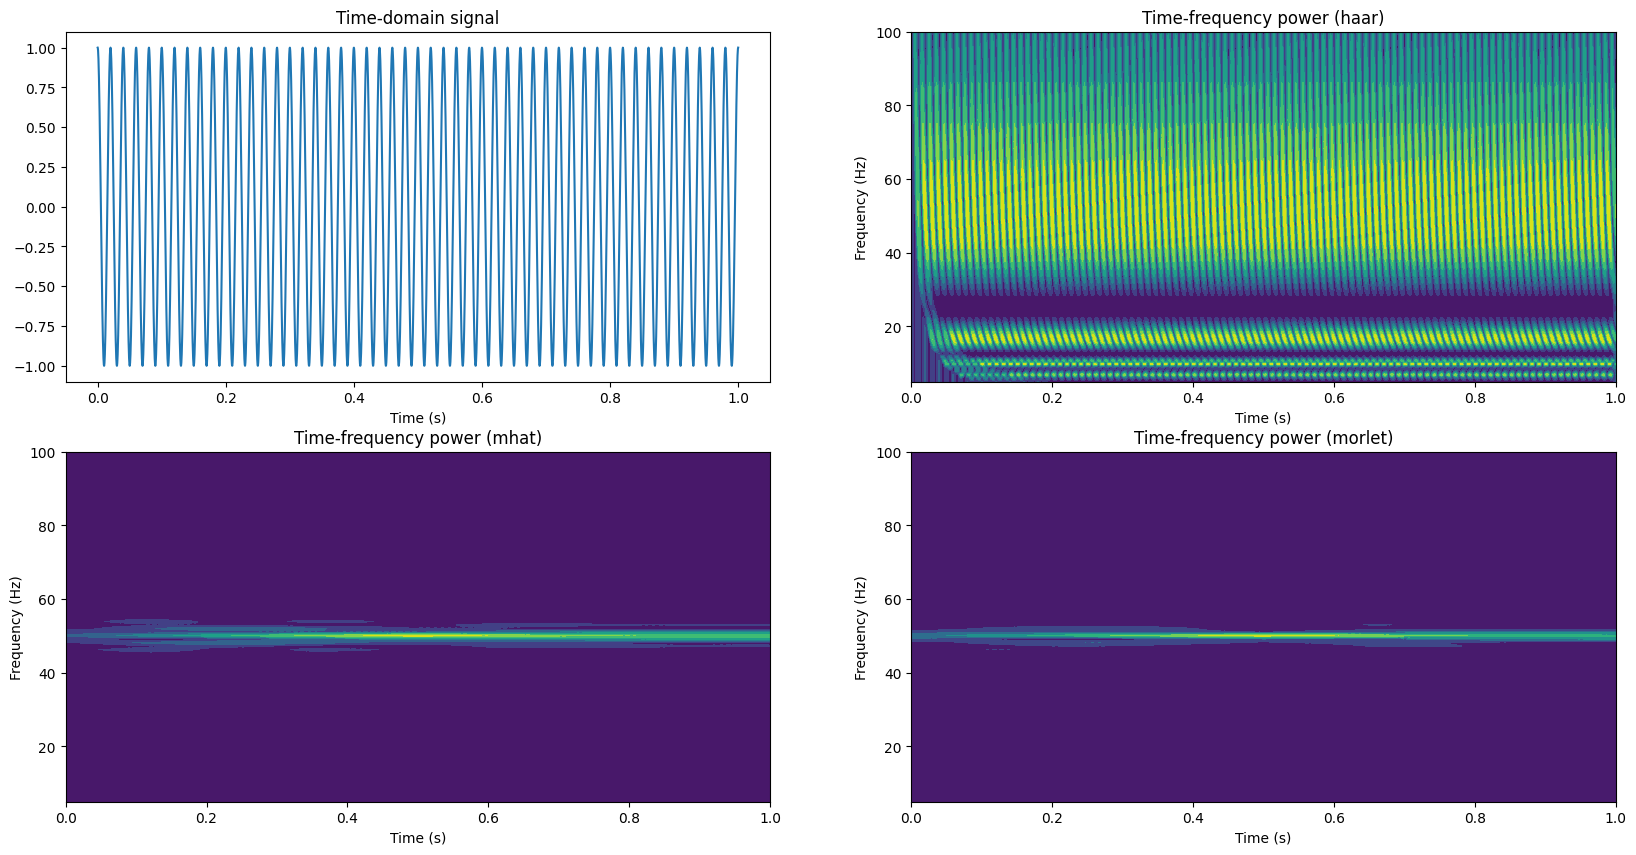

In [19]:
# создание сигнала
t_cos50 = np.linspace(0, 1, 5000)
signal_cos50 = cos_signal(t_cos50, [50])

# Словарь вейвлетов
wavelet_dict = {'haar': wavelet_haar, 'mhat': wavelet_mhat, 'morlet': wavelet_morlet}

# Перебираемые частоты вейвлетов
freqs_cos50 = np.linspace(5, 100, 100)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(t_cos50, signal_cos50)
axs[0, 0].set_title("Time-domain signal")
axs[0, 0].set_xlabel('Time (s)')

# Цикл по всем вейвлетам в словаре
for i, (wavelet_name, wavelet_func) in enumerate(wavelet_dict.items()):
    tf = make_spectrogram(wavelet_func, t_cos50, signal_cos50, freqs_cos50, shift=1.98)
    
    # Выбор текущего графика
    ax = axs[(i+1)//2, (i+1)%2]
    
    ax.contourf(t_cos50, freqs_cos50, tf)
    ax.set_title(f"Time-frequency power ({wavelet_name})")
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

# Показать график
plt.show()

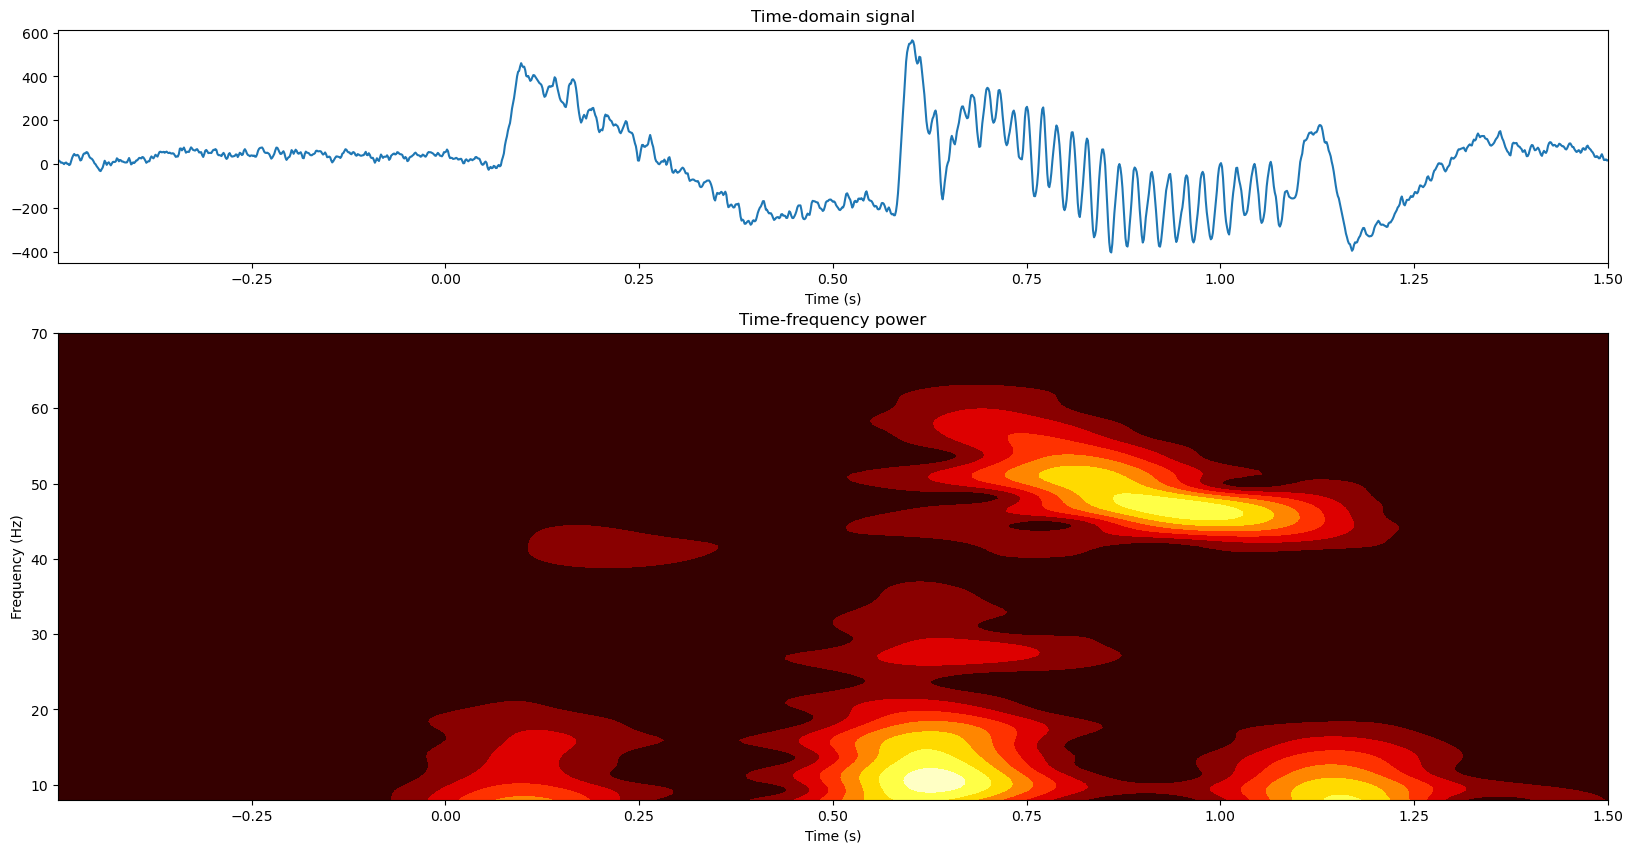

In [15]:
data = sio.loadmat('./data/Lab6_Data.mat') # Import file with matlab type
t3 = data['timevec'][0]
signal3 = data['data'][0]

freqs3 = np.linspace(8, 70, 150)
tf3 = make_spectrogram(wavelet_morlet, t3, signal3, freqs3, shift=1.35, alpha=0.14)

fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 2]})

axs[0].plot(t3, signal3)
axs[0].set_xlim(t3[0], t3[-1])
axs[0].set_title("Time-domain signal")
axs[0].set_xlabel('Time (s)')

axs[1].contourf(t3, freqs3, tf3, cmap=cm.hot)
axs[1].set_title("Time-frequency power")
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')
plt.show()

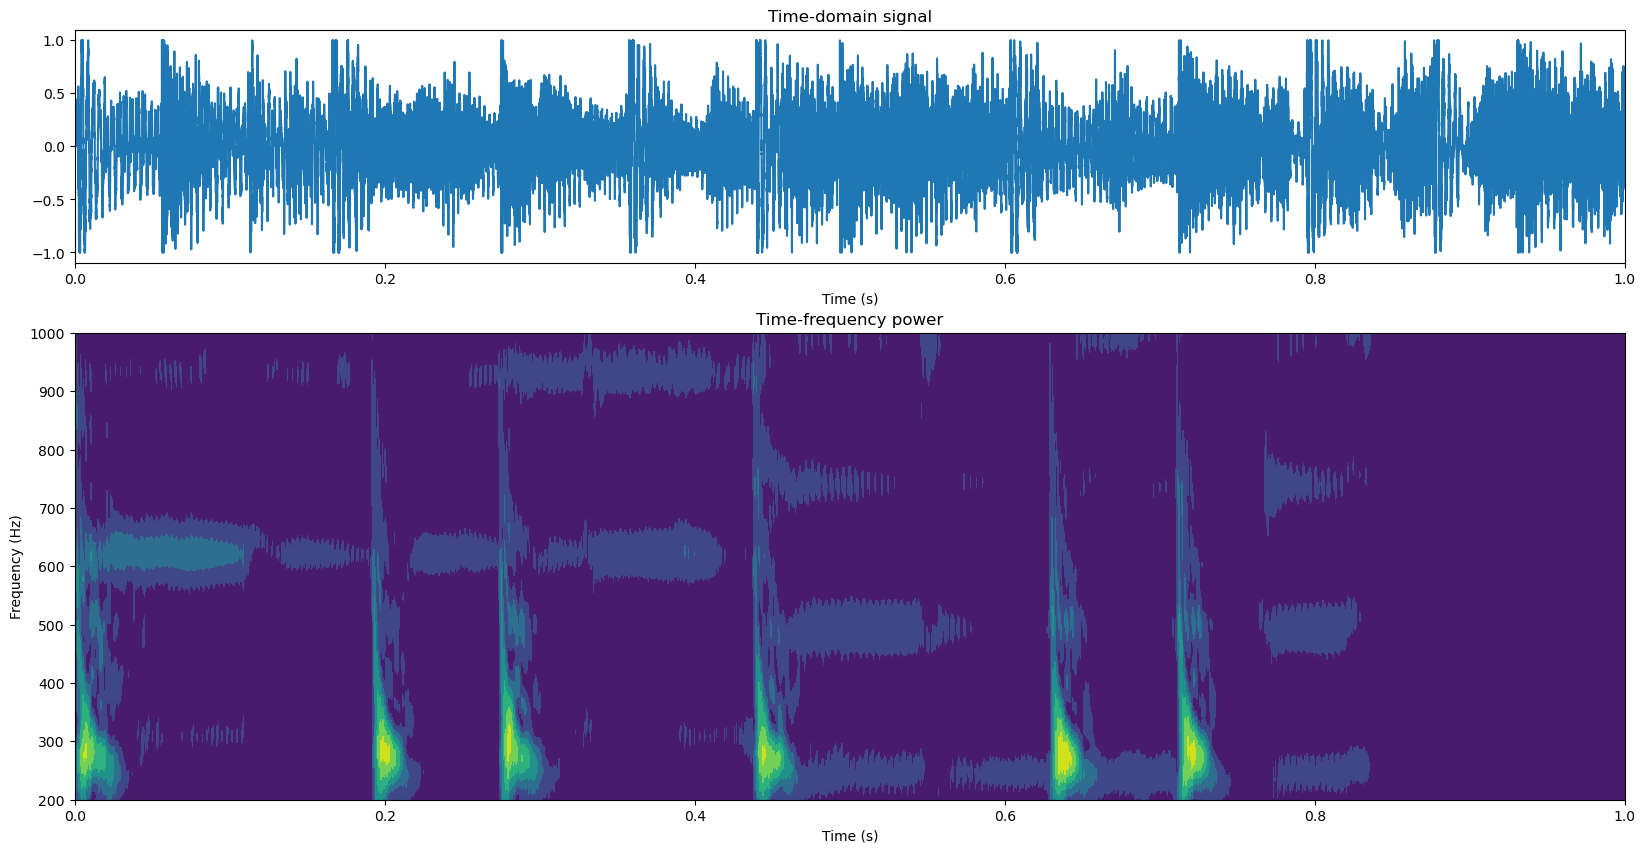

In [18]:
# 1) With

# Need to deal with calculation
# !ffmpeg -ss 00:00:30.00 -t 5 -i ./data/Linkin_Park_-_Runaway.mp3 -acodec copy ./data/Linkin_Park.mp3
#

signal_nokia, srate = a2n.audio_from_file("./data/Linkin_Park.mp3")
t_nokia = np.linspace(0, 1, num=len(signal_nokia))
freqs_nokia = np.linspace(200, 1000, 200)

tf_nokia = make_spectrogram(wavelet_morlet, t_nokia, signal_nokia, freqs_nokia, shift=1.5, alpha=0.01)
fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 2]})

axs[0].plot(t_nokia, signal_nokia)
axs[0].set_xlim(t_nokia[0], t_nokia[-1])
axs[0].set_title("Time-domain signal")
axs[0].set_xlabel('Time (s)')

axs[1].contourf(t_nokia, freqs_nokia, tf_nokia)
axs[1].set_title("Time-frequency power")
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')
plt.show()

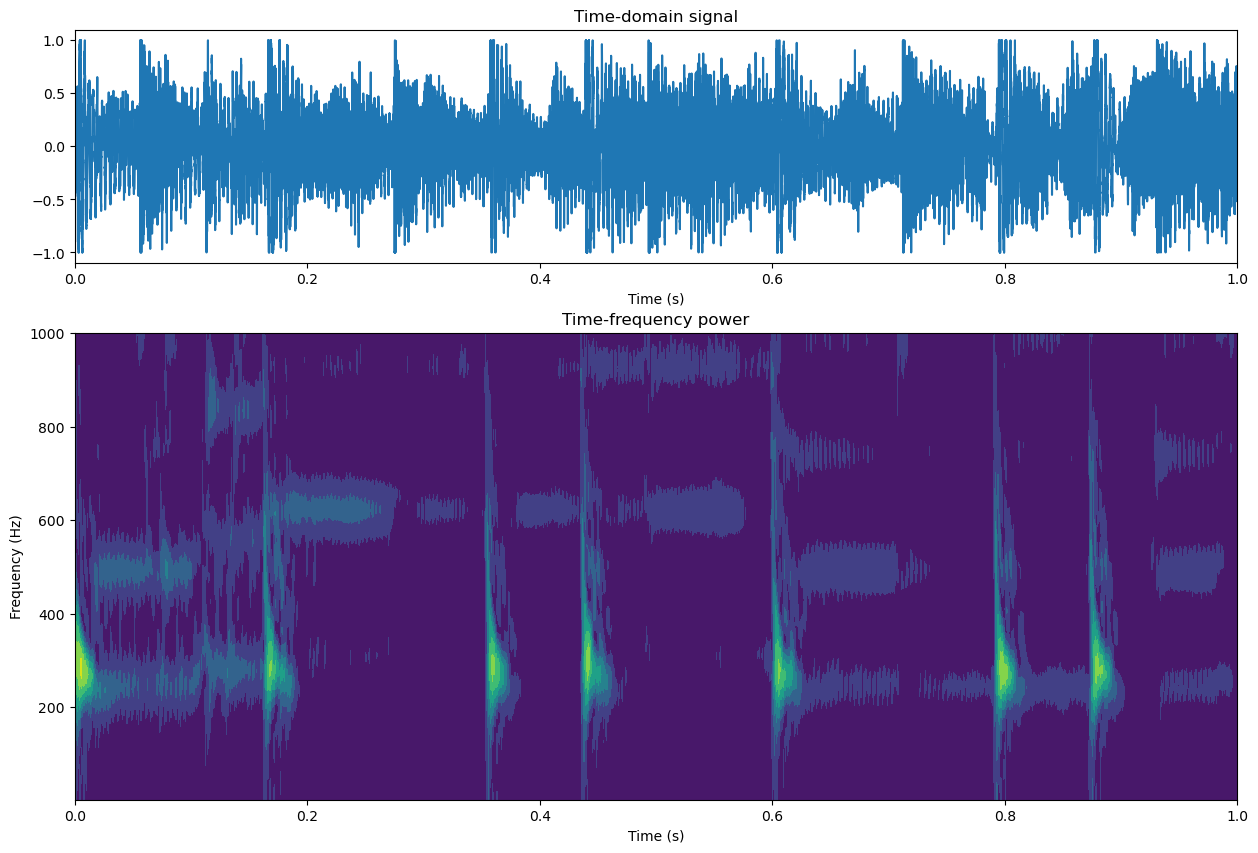

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve
import scipy.io as sio
import warnings
import seaborn as sns
import audio2numpy as a2n

warnings.filterwarnings('ignore')

def make_spectrogram(wavelet_function, t, signal, freqs, shift=1.0, **args):
    # Пустой список для хранения вейвлетов
    wavelets = []
    # Цикл по всем частотам
    for freq in freqs:
        wavelet = wavelet_function(t, freq, **args)
        # Центрирование вейвлета
        wavelet = np.roll(wavelet, int(-len(wavelet) / shift))
        wavelets.append(wavelet)
    # Преобразование списка в массив NumPy
    wavelets = np.array(wavelets)

    # Пустой список для хранения результатов свертки
    tf = []
    # Цикл по всем вейвлетам
    for wavelet in wavelets:
        # Свертка вейвлета и сигнала
        tf.append(np.abs(convolve(signal, wavelet, 'same')))
    # Преобразование списка в массив NumPy
    tf = np.array(tf)

    return tf

def wavelet_morlet(t, peak_freq=1.0, alpha=1.0):
    psi = np.exp(-t**2 / alpha**2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация


signal_mi, srate = a2n.audio_from_file("./data/Linkin_Park.mp3")
t_mi = np.linspace(0, 1, num=len(signal_mi))

# Перебираемые частоты вейвлетов
freqs_mi = np.linspace(2, 1000, 500)
tf_mi = make_spectrogram(wavelet_morlet, t_mi, signal_mi, freqs_mi, shift=1.98, alpha=0.008)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 2]})

axs[0].plot(t_mi, signal_mi)
axs[0].set_xlim(t_mi[0], t_mi[-1])
axs[0].set_title("Time-domain signal")
axs[0].set_xlabel('Time (s)')

axs[1].contourf(t_mi, freqs_mi, tf_mi)
axs[1].set_title("Time-frequency power")
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')
plt.show()